In [1]:
import pickle
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Load data from each band (assuming files are named accordingly)
with open('new_data/pd_on vs hc/delta.pkl', 'rb') as f:
    delta_data = pickle.load(f)['data']
with open('new_data/pd_on vs hc/theta.pkl', 'rb') as f:
    theta_data = pickle.load(f)['data']
with open('new_data/pd_on vs hc/alpha.pkl', 'rb') as f:
    alpha_data = pickle.load(f)['data']
with open('new_data/pd_on vs hc/beta.pkl', 'rb') as f:
    beta_data = pickle.load(f)['data']
with open('new_data/pd_on vs hc/gamma.pkl', 'rb') as f:
    gamma_data = pickle.load(f)['data']

In [3]:
# Stack the bands along the third dimension
data = np.stack([delta_data, theta_data, alpha_data, beta_data, gamma_data], axis=-1)  # shape: (5580, 32, 5)

In [4]:
data.shape

(5580, 32, 5)

In [5]:
# Load labels (assume the labels are the same for each band)
with open('new_data/pd_on vs hc/gamma.pkl', 'rb') as f:
    labels = pickle.load(f)['labels']

In [6]:
# Standardize the data across the flattened feature axis
data = data.reshape(-1, data.shape[-2] * data.shape[-1])
scaler = StandardScaler()
data = scaler.fit_transform(data).reshape(-1, 32, 5)

In [7]:
data.shape

(5580, 32, 5)

In [8]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42, stratify=labels)

In [9]:
X_train.shape

(5022, 32, 5)

In [9]:
# Build the CNN model
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 5, 1)),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.3),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Use sigmoid if labels are not one-hot encoded
])

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/20
142/142 [==============================] - 10s 69ms/step - loss: 0.6402 - accuracy: 0.6442 - val_loss: 0.5416 - val_accuracy: 0.7634
Epoch 2/20
142/142 [==============================] - 10s 67ms/step - loss: 0.5021 - accuracy: 0.7676 - val_loss: 0.4248 - val_accuracy: 0.8708
Epoch 3/20
142/142 [==============================] - 10s 67ms/step - loss: 0.4077 - accuracy: 0.8214 - val_loss: 0.3334 - val_accuracy: 0.8489
Epoch 4/20
142/142 [==============================] - 10s 70ms/step - loss: 0.3460 - accuracy: 0.8584 - val_loss: 0.3220 - val_accuracy: 0.9165
Epoch 5/20
142/142 [==============================] - 10s 67ms/step - loss: 0.2760 - accuracy: 0.8918 - val_loss: 0.2419 - val_accuracy: 0.9443
Epoch 6/20
142/142 [==============================] - 10s 68ms/step - loss: 0.2704 - accuracy: 0.9077 - val_loss: 0.1947 - val_accuracy: 0.9583
Epoch 7/20
142/142 [==============================] - 10s 68ms/step - loss: 0.2217 - accuracy: 0.9181 - val_loss: 0.2076 - val_accuracy:

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import KFold


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies, fold_precisions, fold_recalls, fold_f1s, fold_aucs = [], [], [], [], []
history_list = []

for fold, (train_index, test_index) in enumerate(kf.split(data)):
    print(f"Training fold {fold + 1}...")

    # Split the data
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # One-hot encode the labels for CNN training
    y_train = to_categorical(y_train)
    y_test_categorical = to_categorical(y_test)

    # Build CNN model
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 5, 1)),
        MaxPooling2D(pool_size=(2, 1)),
        Dropout(0.3),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 1)),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model and save history for training curve
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test_categorical), verbose=1)
    history_list.append(history)

    # Predictions and evaluation
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # ROC and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    fold_aucs.append(roc_auc)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix for Fold {fold + 1}')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Store metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)

    fold_accuracies.append(acc)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1s.append(f1)

    print(f"Fold {fold + 1} - Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, AUC: {roc_auc}")


In [14]:
# Average metrics across folds
print("\nCross-Validation Results:")
print(f"Average Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Average Precision: {np.mean(fold_precisions):.4f}")
print(f"Average Recall: {np.mean(fold_recalls):.4f}")
print(f"Average F1 Score: {np.mean(fold_f1s):.4f}")
print(f"Average AUC Score: {np.mean(fold_aucs):.4f}")


Cross-Validation Results:
Average Accuracy: 0.9670
Average Precision: 0.9590
Average Recall: 0.9738
Average F1 Score: 0.9662
Average AUC Score: 0.9929


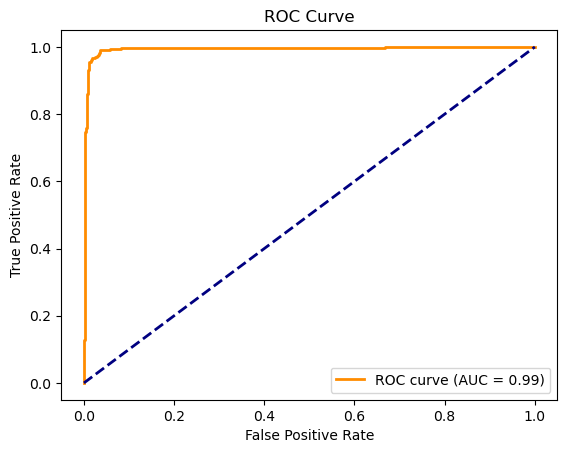

In [15]:
# Plot ROC Curve for the last fold
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

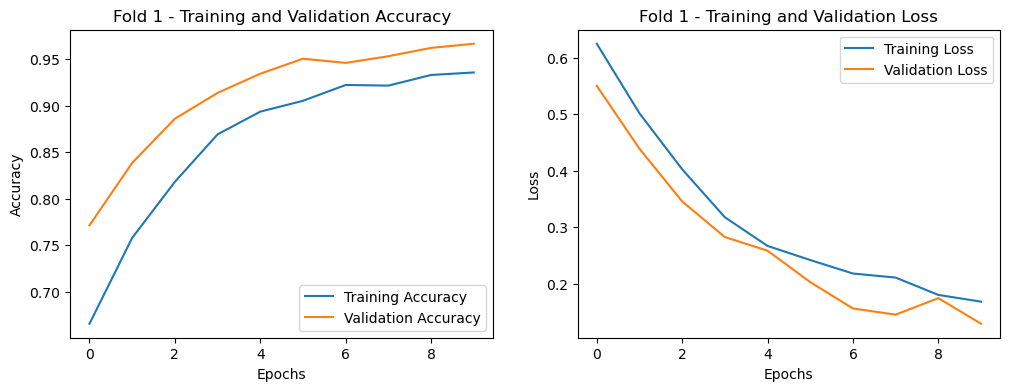

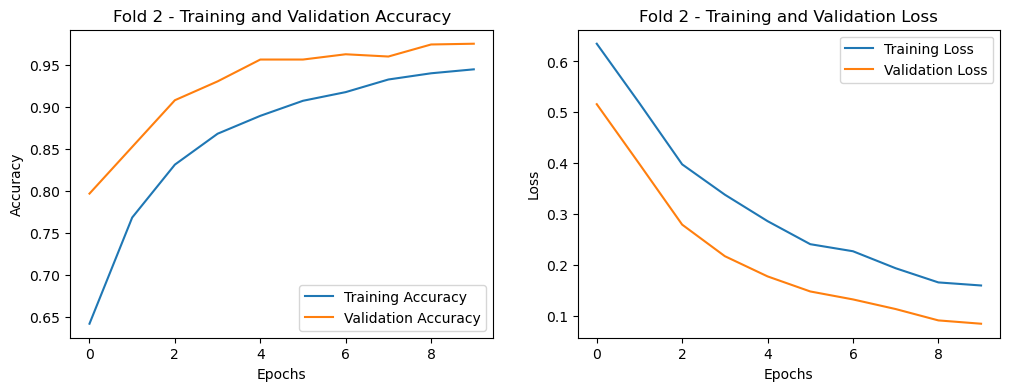

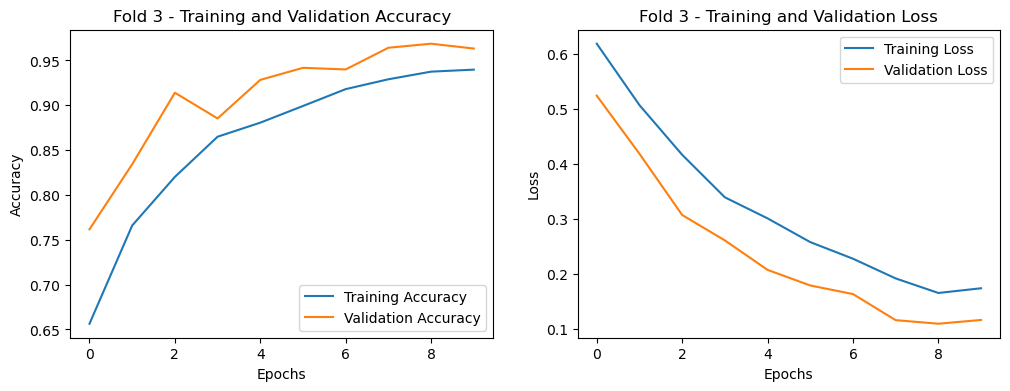

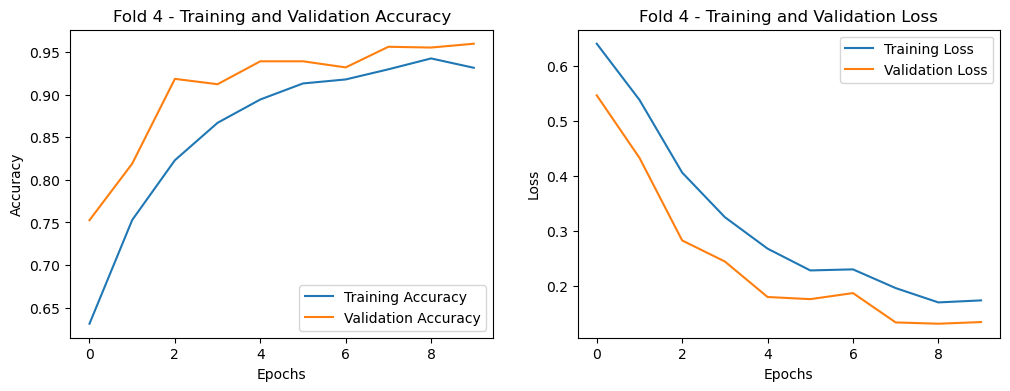

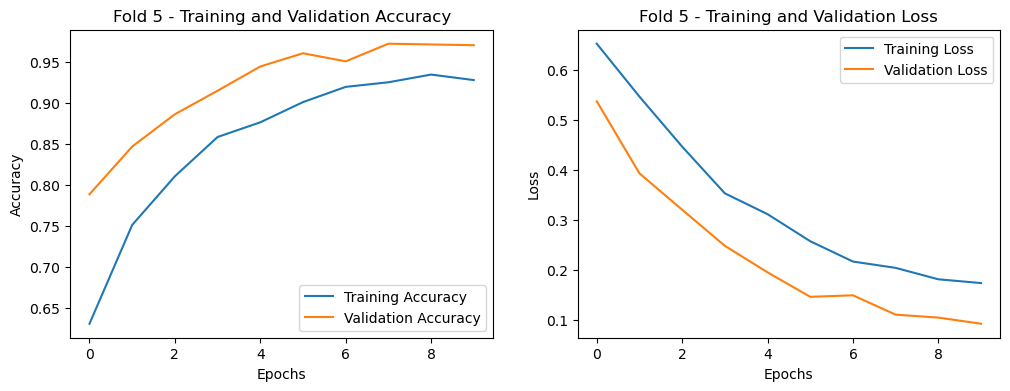

In [16]:
# Plot Training and Validation Accuracy & Loss for each fold
for i, history in enumerate(history_list):
    plt.figure(figsize=(12, 4))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {i + 1} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i + 1} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()